# NovaPay — Fraudulent Transaction Detection (Final Notebook)

This notebook compiles the full end‑to‑end project into a single, reviewer‑friendly narrative:

1. Problem framing & success criteria
2. Data assessment & quality checks
3. Cleaning & preparation
4. Feature engineering & EDA
5. Baseline models (LogReg, RF)
6. Advanced modeling & imbalance handling
7. Explainability (local SHAP) + stakeholder templates

**Note:** Sections are taken from the original notebooks and stitched together with short “so‑what” headers.


## How to read / run
- You can **run top‑to‑bottom** if you have the same project folder structure (data paths as used in the original notebooks).
- If you only want results, scroll to **Baseline Models**, **Advanced Models**, and **Explainability** sections.



---
## Week 1 · Day 1 — Kickoff



# NovaPay Fraud Environment & Success Criteria

## Business context
NovaPay is a digital-first cross-border money transfer company headquartered in Toronto with operations across the United Kingdom, Canada, and the United States. It enables customers to send, receive, and hold multiple currencies with a strong focus on affordability, speed, and a seamless digital experience. Secure transaction processing is central to NovaPay’s customer trust, operational performance, and regulatory standing, making early and accurate fraud detection a strategic priority.

## Fraud environment: key risks
NovaPay’s fraud environment reflects common digital payments threats, amplified by cross-border complexity and real-time expectations:

- **Identity theft & account takeover (ATO):** attackers compromise accounts (phishing, credential stuffing, SIM-swap) and initiate unauthorized transfers.
- **Unauthorized payments:** fraudulent transactions initiated without legitimate customer intent.
- **Transaction laundering / mule networks:** illicit funds routed through chains of accounts and corridors to obscure origin and destination.
- **Device/IP abuse:** suspicious IPs, new devices, and mismatches between declared location and observed IP geography.
- **Velocity anomalies:** bursts of activity over short windows (e.g., 1h/24h transaction velocity) suggesting automation or laundering.
- **Cross-border corridor risk:** certain routes/currency corridors may have elevated risk due to fraud concentration, weaker verification, or known mule flows.

## Operational and regulatory constraints
Fraud controls must operate under tight constraints:

- **Real-time processing:** transactions may need instant approval/decline decisions, limiting manual review.
- **Rules-based limits:** static rules can become outdated and are vulnerable to adaptive fraud tactics.
- **False positives:** blocking legitimate users harms experience and can increase churn.
- **Compliance expectations:** AML and KYC requirements mean decisions should be **auditable and explainable**, especially for high-impact declines and account restrictions.

## Data and modelling implications (early risks)
Fraud detection performance depends heavily on data and labels:

- **Label reliability:** fraud labels may come from investigations, chargebacks, or disputes, which can be delayed or incomplete.
- **Class imbalance:** fraud is typically rare in production. Models must handle imbalance so they do not default to predicting “non-fraud.”
- **Bias/fairness risk:** features tied to geography, KYC tiers, IP risk, and internal scores can produce uneven outcomes across segments. We must monitor error rates (false positives/false negatives) across meaningful groups (e.g., corridor, home country, KYC tier) and ensure legitimate users are not disproportionately impacted.

## Success criteria (what “good” looks like)

### Business success
A successful solution should:
1. **Reduce fraud losses** by catching more fraud earlier.
2. **Lower operational burden** by prioritizing the highest-risk cases for review.
3. **Protect customer experience** by keeping false positives manageable.
4. **Support compliance** via transparent, auditable, explainable decisions.

### Model success (technical KPIs)
The model should:
- Improve **fraud recall** versus a baseline (rules/manual process), while controlling alert volume.
- Balance **precision vs recall** to prevent analyst overload.
- Report **Recall, Precision, F1, PR-AUC** (especially important for imbalanced fraud labels).
- Provide **transaction-level explainability** (e.g., SHAP) to show why a transaction was flagged.
- Be designed for deployment (FastAPI scoring service) as a step toward real-time production scoring.

## Week 1 deliverables mapping
- **Day 1:** Fraud environment + success criteria (this document)
- **Day 2:** Data assessment report (schema, imbalance, bias risks, label reliability)
- **Day 3:** Cleaning pipeline + cleaned dataset + cleaning notes
- **Day 4:** Engineered features + EDA visuals and comparisons fraud vs non-fraud
- **Day 5:** Feature set finalized and ready for modelling (documentation included)


---
## Week 1 · Day 2 — Data Assessment



In [8]:
# Core data manipulation libraries
import pandas as pd
import numpy as np

# Path to the raw dataset
# Keeping raw data untouched is best practice
DATA_PATH = "../data/raw/nova_pay_combined.csv"

# Load the dataset into a pandas DataFrame
df = pd.read_csv(DATA_PATH)

# Display dataset dimensions (rows, columns)
df.shape

(11400, 26)

In [9]:
# Preview the first few rows to understand the structure
df.head()

,transaction_id,customer_id,timestamp,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,fee,...,ip_risk_score,kyc_tier,account_age_days,device_trust_score,chargeback_history_count,risk_score_internal,txn_velocity_1h,txn_velocity_24h,corridor_risk,is_fraud
0,fee8542d-8ee6-4b0d-9671-c294dd08ed26,402cccc9-28de-45b3-9af7-cc5302aa1f93,2022-10-03 18:40:59.468549+00:00,US,USD,CAD,ATM,278.19,278.19,4.25,...,0.123,standard,263,0.522,0,0.223,0,0,0.0,0
1,bfdb9fc1-27fe-4a85-b043-4d813d679259,67c2c6b3-ef0a-4777-a3f1-c84a851bb6ad,2022-10-03 20:39:38.468549+00:00,CA,CAD,MXN,web,208.51,154.29,4.24,...,0.569,standard,947,0.475,0,0.268,0,1,0.0,0
2,fc855034-3ea5-4993-9afa-b511d93fe5e8,6d0d9b27-fa26-45f8-93b1-2df29d182d9c,2022-10-03 23:02:43.468549+00:00,US,USD,CNY,mobile,160.33,160.33,2.70,...,0.437,enhanced,367,0.939,0,0.176,0,0,0.0,0
3,2cf8c08e-42ec-444d-a755-34b9a2a0a4ca,7bd5200c-5d19-44f0-9afe-8b339a05366b,2022-10-04 01:08:53.468549+00:00,US,USD,EUR,mobile,59.41,59.41,2.22,...,0.594,standard,147,0.551,0,0.391,0,0,0.0,0
4,d907a74d-b426-438d-97eb-dbe911aca91c,70a93d26-8e3a-4179-900c-a4a7a74d08e5,2022-10-04 09:35:03.468549+00:00,US,USD,INR,mobile,200.96,200.96,3.61,...,0.121,enhanced,257,0.894,0,0.257,0,0,0.0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11400 entries, 0 to 11399
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   transaction_id             11400 non-null  object 
 1   customer_id                11400 non-null  object 
 2   timestamp                  11371 non-null  object 
 3   home_country               11400 non-null  object 
 4   source_currency            11400 non-null  object 
 5   dest_currency              11400 non-null  object 
 6   channel                    11400 non-null  object 
 7   amount_src                 11400 non-null  object 
 8   amount_usd                 11095 non-null  float64
 9   fee                        11105 non-null  float64
 10  exchange_rate_src_to_dest  11400 non-null  float64
 11  device_id                  11400 non-null  object 
 12  new_device                 11400 non-null  bool   
 13  ip_address                 11095 non-null  obj

In [10]:
# Summary statistics for both numerical and categorical features
# Transposed for easier reading
df.describe(include="all").T
#df.describe()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
transaction_id,11400,11200,9cfbbce9-979c-4d34-bf5a-98531362bd9a,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_id,11400,1315,402cccc9-28de-45b3-9af7-cc5302aa1f93,1510,NaN,NaN,NaN,NaN,NaN,NaN,NaN
timestamp,11371,11141,0000-00-00T00:00:00Z,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
home_country,11400,7,US,7940,NaN,NaN,NaN,NaN,NaN,NaN,NaN
source_currency,11400,3,USD,8031,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dest_currency,11400,9,NGN,1474,NaN,NaN,NaN,NaN,NaN,NaN,NaN
channel,11400,12,mobile,6366,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amount_src,11400,9856,100.0,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amount_usd,11095.0,NaN,NaN,NaN,452.022083,1403.973062,7.23,92.465,163.48,302.19,12498.57
fee,11105.0,NaN,NaN,NaN,100.309441,958.128504,-1.0,2.38,3.5,5.55,9999.99


In [11]:
# Count of fraudulent vs non-fraudulent transactions
df["is_fraud"].value_counts()

is_fraud
0    10403
1      997
Name: count, dtype: int64

In [12]:
# Percentage distribution of fraud labels
# Useful for understanding class imbalance severity
df["is_fraud"].value_counts(normalize=True) * 100

is_fraud
0    91.254386
1     8.745614
Name: proportion, dtype: float64

The fraud label is highly imbalanced, with fraudulent transactions representing a small minority
of all observations. This confirms that standard accuracy-based evaluation would be misleading,
and imbalance-aware modelling techniques will be required.

In [13]:
# Count missing values per column
missing_counts = df.isna().sum().sort_values(ascending=False)

# Display only columns with missing data
missing_counts[missing_counts > 0]

ip_address            305
amount_usd            305
ip_country            301
kyc_tier              300
fee                   295
device_trust_score    295
timestamp              29
dtype: int64

In [14]:
# Convert missing counts to percentages for better interpretation
(missing_counts / len(df) * 100).round(2)

ip_address                   2.68
amount_usd                   2.68
ip_country                   2.64
kyc_tier                     2.63
fee                          2.59
device_trust_score           2.59
timestamp                    0.25
location_mismatch            0.00
corridor_risk                0.00
txn_velocity_24h             0.00
txn_velocity_1h              0.00
risk_score_internal          0.00
chargeback_history_count     0.00
account_age_days             0.00
ip_risk_score                0.00
transaction_id               0.00
customer_id                  0.00
new_device                   0.00
device_id                    0.00
exchange_rate_src_to_dest    0.00
amount_src                   0.00
channel                      0.00
dest_currency                0.00
source_currency              0.00
home_country                 0.00
is_fraud                     0.00
dtype: float64

In [15]:
# Check for fully duplicated rows
df.duplicated().sum()

200

In [16]:
# Check for duplicate transaction IDs
# transaction_id should be unique per transaction
df.duplicated(subset=["transaction_id"]).sum()

200

In [18]:
# Check data types of amount columns
df[["amount_src", "amount_usd"]].dtypes

amount_src     object
amount_usd    float64
dtype: object


---
## Week 1 · Day 3 — Cleaning



In [1]:
# Core libraries
import pandas as pd
import numpy as np

# Load raw dataset (do NOT modify raw files)
RAW_PATH = "../data/raw/nova_pay_combined.csv"
df = pd.read_csv(RAW_PATH)

# Keep an original copy for reference
df_raw = df.copy()

df.shape

(11400, 26)

In [2]:
# Convert timestamp to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

# Count invalid timestamps
invalid_timestamps = df["timestamp"].isna().sum()
invalid_timestamps

61

In [3]:
# Drop rows with invalid timestamps
df = df.dropna(subset=["timestamp"])

df.shape

(11339, 26)

In [4]:
# Identify duplicate transaction IDs
dup_count = df.duplicated(subset=["transaction_id"]).sum()
dup_count

199

In [5]:
# Sort so the latest transaction comes last
df = df.sort_values("timestamp")

# Drop duplicates, keeping the latest record per transaction_id
df = df.drop_duplicates(subset=["transaction_id"], keep="last")

df.shape

(11140, 26)

In [6]:
# Convert source amount to numeric (non-numeric -> NaN)
df["amount_src_num"] = pd.to_numeric(df["amount_src"], errors="coerce")

# amount_usd is already numeric, but ensure consistency
df["amount_usd_num"] = pd.to_numeric(df["amount_usd"], errors="coerce")

# Check how many values failed conversion
df[["amount_src_num", "amount_usd_num"]].isna().sum()

amount_src_num      4
amount_usd_num    300
dtype: int64

In [7]:
# --- Amount cleaning step 2: Identify logically invalid values ---

# A transaction amount should be strictly positive (> 0)
invalid_amount_mask = (
    (df["amount_src_num"] <= 0) |
    (df["amount_usd_num"] <= 0)
)

# Count how many rows violate this rule
invalid_amounts_before = invalid_amount_mask.sum()
invalid_amounts_before

100

In [8]:
# Inspect a sample of transactions with invalid amounts
df.loc[invalid_amount_mask, ["transaction_id", "amount_src_num", "amount_usd_num"]].head(10)

,transaction_id,amount_src_num,amount_usd_num
328,3bcab4c7-dc2e-416c-b57e-266aafe46a47,-37.08,37.08
564,8e0f5d06-a518-4b0c-ab83-5208837bc5be,-176.92,176.92
576,064c0207-1b3c-4328-b0b9-7ea68a70ee1f,-702.71,702.71
602,1d2465a1-14b6-48d9-a74d-76a2dddf5e65,-203.83,150.83
655,57b6e089-e25b-4213-8e75-df2c0ab23432,-82.80,82.80
788,1d2ddf81-e4c7-4684-bbed-c1b6446c729e,-143.13,143.13
798,883403f5-fd2f-4b39-824e-9710485a983e,-168.96,211.20
1311,e9c7f2cb-f2de-4603-b38f-f2f66ec1eee1,-165.36,NaN
1418,ae0c1cd8-7f7e-4424-938f-7f7242ff197f,-504.71,504.71
1429,873a17a6-91b1-434c-9908-2bf57fefa746,-144.10,144.10


In [9]:
# --- Amount cleaning step 3: Impute missing (NaN) values with median ---

# Compute medians from the current (converted) data
src_median = df["amount_src_num"].median()
usd_median = df["amount_usd_num"].median()

src_median, usd_median

(159.05, 163.64499999999998)

In [10]:
# Fill NaN values in the numeric amount columns with the median
df["amount_src_num"] = df["amount_src_num"].fillna(src_median)
df["amount_usd_num"] = df["amount_usd_num"].fillna(usd_median)

# Verify that no NaNs remain in amount columns
df[["amount_src_num", "amount_usd_num"]].isna().sum()

amount_src_num    0
amount_usd_num    0
dtype: int64

In [11]:
# --- Amount cleaning step 4: Confirm invalid amounts remain ---

invalid_amount_mask = (
    (df["amount_src_num"] <= 0) |
    (df["amount_usd_num"] <= 0)
)

invalid_amounts_after = invalid_amount_mask.sum()
invalid_amounts_after

100

In [12]:
# --- Amount cleaning step 5: Drop transactions with invalid amounts ---

# Keep only rows with strictly positive amounts
df = df[
    (df["amount_src_num"] > 0) &
    (df["amount_usd_num"] > 0)
]

df.shape

(11040, 28)

In [13]:
# Save cleaned dataset for downstream analysis
OUTPUT_PATH = "../data/processed/cleaned_transactions.csv"
df.to_csv(OUTPUT_PATH, index=False)

OUTPUT_PATH

'../data/processed/cleaned_transactions.csv'


---
## Week 1 · Day 4 — Feature Engineering & EDA



In [1]:
# Core libraries
import pandas as pd
import numpy as np

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset produced on Day 3
DATA_PATH = "../data/processed/cleaned_transactions.csv"
df = pd.read_csv(DATA_PATH)

# Ensure timestamp is parsed correctly
df["timestamp"] = pd.to_datetime(df["timestamp"])

df.shape

(11040, 28)

In [4]:
# --- Temporal feature engineering ---

# Hour of transaction (0–23)
df["tx_hour"] = df["timestamp"].dt.hour

# Day of week (0 = Monday, 6 = Sunday)
df["tx_weekday"] = df["timestamp"].dt.weekday

# Weekend indicator
df["is_weekend"] = df["tx_weekday"].isin([5, 6]).astype(int)

df[["tx_hour", "tx_weekday", "is_weekend"]].head()

,tx_hour,tx_weekday,is_weekend
0,18,0,0
1,20,0,0
2,23,0,0
3,1,1,0
4,9,1,0


C:\Users\caspe\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


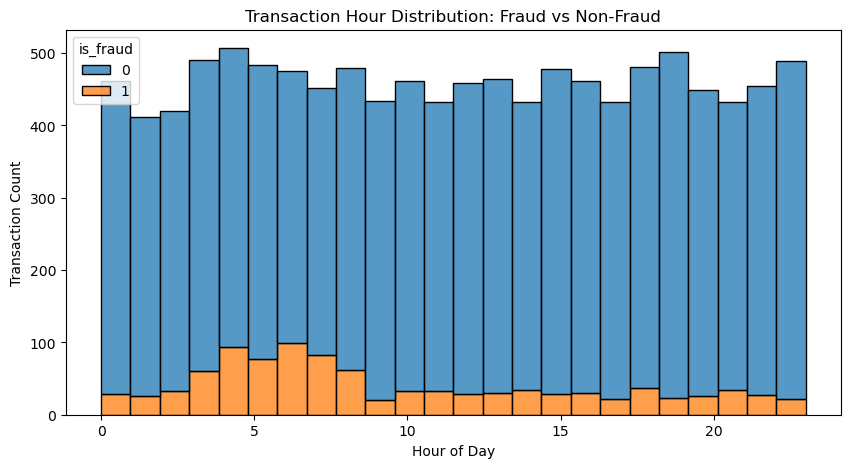

In [5]:
# Plot distribution of transaction hour by fraud label
plt.figure(figsize=(10, 5))
sns.histplot(
    data=df,
    x="tx_hour",
    hue="is_fraud",
    bins=24,
    multiple="stack"
)
plt.title("Transaction Hour Distribution: Fraud vs Non-Fraud")
plt.xlabel("Hour of Day")
plt.ylabel("Transaction Count")
plt.show()

Transaction frequency per customer

In [6]:
# --- Behavioural feature engineering ---

# Transactions per customer
tx_per_customer = (
    df.groupby("customer_id")["transaction_id"]
    .count()
    .rename("tx_count_customer")
)

# Merge back into main dataframe
df = df.merge(tx_per_customer, on="customer_id", how="left")

df[["customer_id", "tx_count_customer"]].head()

,customer_id,tx_count_customer
0,402cccc9-28de-45b3-9af7-cc5302aa1f93,1464
1,67c2c6b3-ef0a-4777-a3f1-c84a851bb6ad,341
2,6d0d9b27-fa26-45f8-93b1-2df29d182d9c,1031
3,7bd5200c-5d19-44f0-9afe-8b339a05366b,781
4,70a93d26-8e3a-4179-900c-a4a7a74d08e5,656


### Fraud rate by customer transaction volume

In [7]:
# Bin customers by transaction count
df["tx_count_bin"] = pd.qcut(
    df["tx_count_customer"],
    q=5,
    duplicates="drop"
)

fraud_rate_by_volume = (
    df.groupby("tx_count_bin")["is_fraud"]
    .mean()
)

fraud_rate_by_volume

C:\Users\caspe\AppData\Local\Temp\ipykernel_9736\3990763208.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("tx_count_bin")["is_fraud"]


tx_count_bin
(0.999, 136.0]      0.360158
(136.0, 781.0]      0.010726
(781.0, 1031.0]     0.007853
(1031.0, 1302.0]    0.043160
(1302.0, 1464.0]    0.008880
Name: is_fraud, dtype: float64

In [9]:
# --- Corridor feature engineering ---

# Combine source and destination currencies
df["corridor"] = (
    df["source_currency"] + "_to_" + df["dest_currency"]
)

df["corridor"].value_counts().head(10)

corridor
USD_to_NGN    1003
USD_to_PHP     922
USD_to_USD     910
USD_to_EUR     904
USD_to_GBP     897
USD_to_CNY     893
USD_to_INR     878
USD_to_CAD     877
USD_to_MXN     484
GBP_to_NGN     308
Name: count, dtype: int64

In [10]:
# Calculate fraud rate per corridor
corridor_fraud_rate = (
    df.groupby("corridor")["is_fraud"]
    .mean()
    .sort_values(ascending=False)
)

corridor_fraud_rate.head(10)

corridor
CAD_to_INR    0.607955
GBP_to_NGN    0.392857
USD_to_MXN    0.266529
GBP_to_EUR    0.150376
USD_to_NGN    0.133599
CAD_to_NGN    0.122951
USD_to_PHP    0.121475
GBP_to_CNY    0.100000
GBP_to_GBP    0.089744
GBP_to_USD    0.088608
Name: is_fraud, dtype: float64

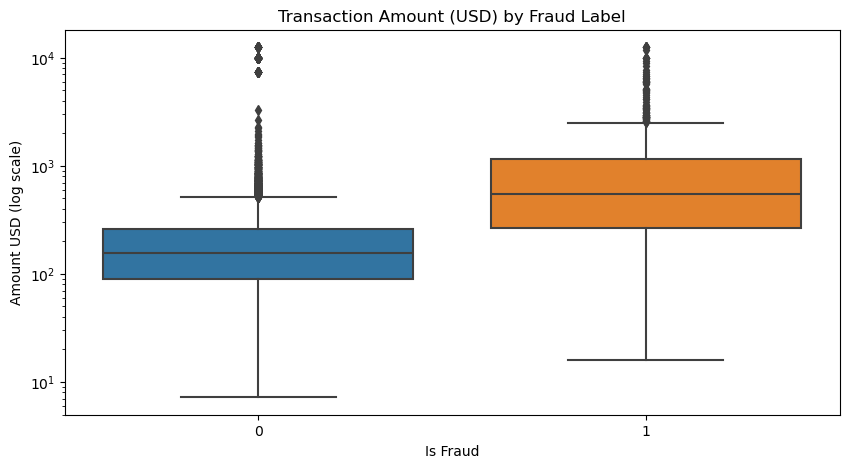

In [11]:
# Compare amount_usd distributions
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df,
    x="is_fraud",
    y="amount_usd_num"
)
plt.yscale("log")
plt.title("Transaction Amount (USD) by Fraud Label")
plt.xlabel("Is Fraud")
plt.ylabel("Amount USD (log scale)")
plt.show()

In [12]:
# Select numeric features for correlation
numeric_features = df.select_dtypes(include=["number"])

# Correlation with fraud label
fraud_corr = (
    numeric_features.corr()["is_fraud"]
    .sort_values(ascending=False)
)

fraud_corr.head(10)

is_fraud                     1.000000
txn_velocity_24h             0.755759
txn_velocity_1h              0.694019
risk_score_internal          0.606001
chargeback_history_count     0.582986
ip_risk_score                0.551614
corridor_risk                0.196307
exchange_rate_src_to_dest    0.153225
fee                          0.133570
amount_usd_num               0.132611
Name: is_fraud, dtype: float64

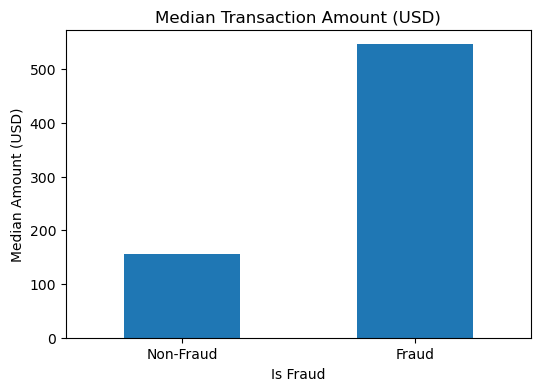

In [15]:
# --- Median transaction amount by fraud label ---

median_amounts = (
    df.groupby("is_fraud")["amount_usd_num"]
    .median()
)

median_amounts.plot(
    kind="bar",
    figsize=(6, 4),
    title="Median Transaction Amount (USD)"
)

plt.xticks([0, 1], ["Non-Fraud", "Fraud"], rotation=0)
plt.ylabel("Median Amount (USD)")
plt.xlabel("Is Fraud")
plt.show()

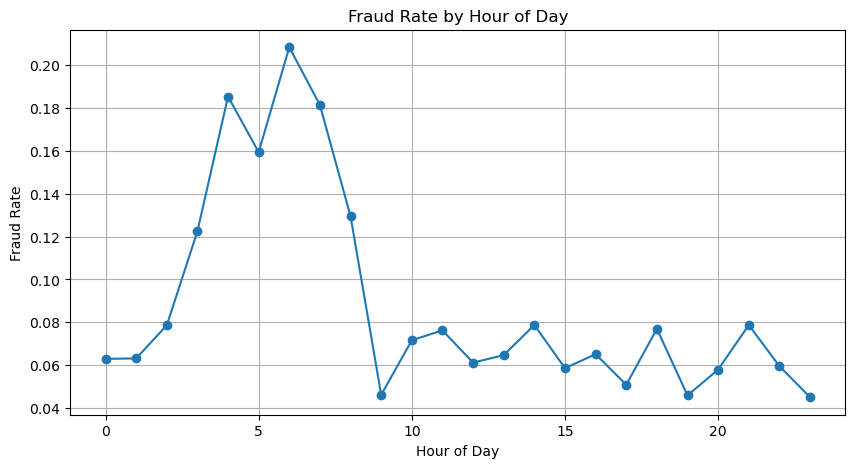

In [16]:
# --- Fraud rate by hour of day ---

fraud_rate_by_hour = (
    df.groupby("tx_hour")["is_fraud"]
    .mean()
)

plt.figure(figsize=(10, 5))
fraud_rate_by_hour.plot(marker="o")

plt.title("Fraud Rate by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Fraud Rate")
plt.grid(True)
plt.show()

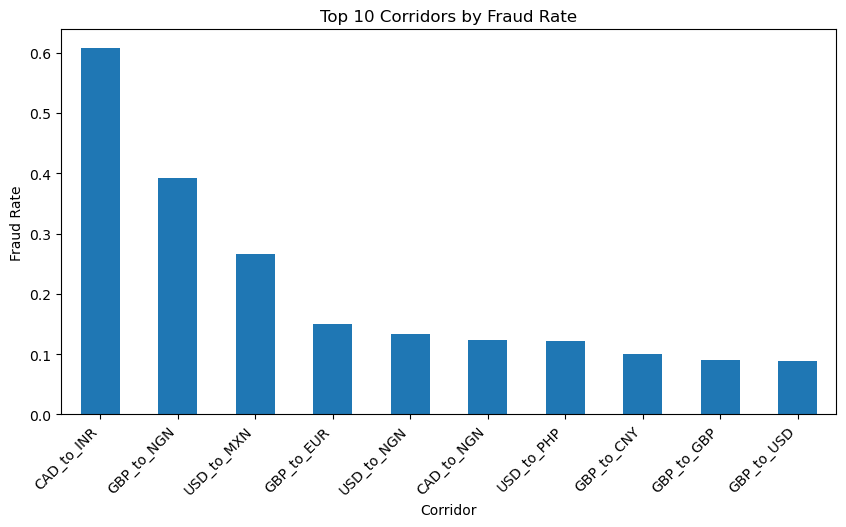

In [17]:
# --- Top 10 corridors by fraud rate ---

top_corridors = corridor_fraud_rate.head(10)

plt.figure(figsize=(10, 5))
top_corridors.plot(kind="bar")

plt.title("Top 10 Corridors by Fraud Rate")
plt.xlabel("Corridor")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=45, ha="right")
plt.show()

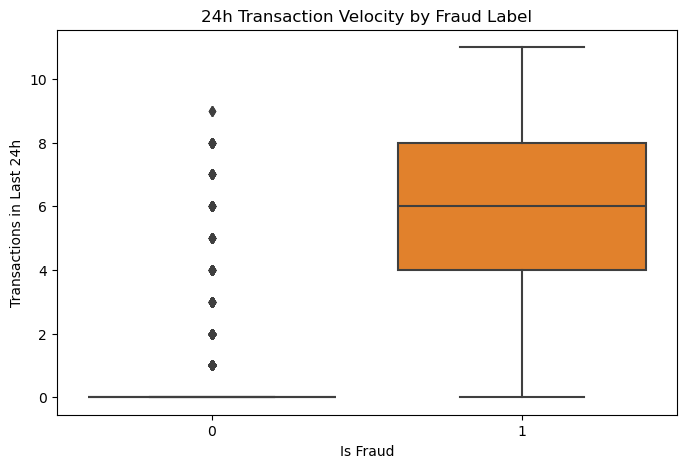

In [18]:
# --- Velocity feature vs fraud ---

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df,
    x="is_fraud",
    y="txn_velocity_24h"
)

plt.title("24h Transaction Velocity by Fraud Label")
plt.xlabel("Is Fraud")
plt.ylabel("Transactions in Last 24h")
plt.show()

In [19]:
# --- Recency feature engineering: preparation ---

# Sort transactions by customer and time
# This is critical for correct recency calculation
df = df.sort_values(
    by=["customer_id", "timestamp"]
).reset_index(drop=True)

In [20]:
# --- Recency feature engineering ---

# Calculate time difference between consecutive transactions per customer
df["time_since_prev_tx"] = (
    df.groupby("customer_id")["timestamp"]
    .diff()
)

# Convert time delta to hours
df["time_since_prev_tx_hours"] = (
    df["time_since_prev_tx"].dt.total_seconds() / 3600
)

In [21]:
# --- Handle missing recency values ---

# First transaction per customer has no previous transaction
# We fill these with a large value to indicate "long inactivity"
recency_median = df["time_since_prev_tx_hours"].median()

df["time_since_prev_tx_hours"] = (
    df["time_since_prev_tx_hours"]
    .fillna(recency_median)
)

recency_median

22.3875

In [22]:
# Quick check of recency feature
df["time_since_prev_tx_hours"].describe()

count    11040.000000
mean       128.353193
std        744.011175
min          0.000000
25%         10.119375
50%         22.387500
75%         46.771319
max      25107.165278
Name: time_since_prev_tx_hours, dtype: float64

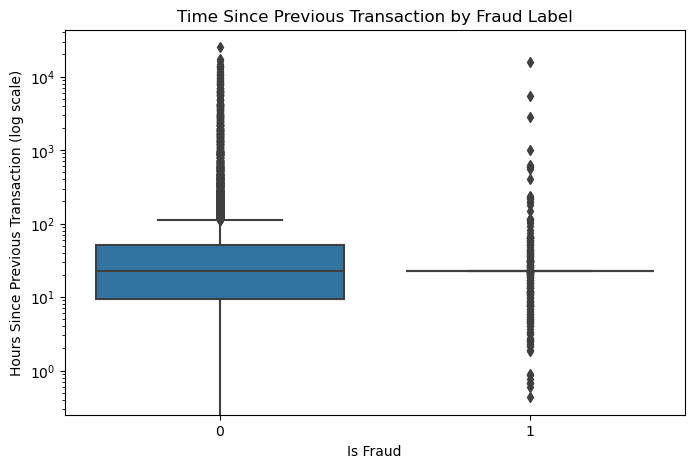

In [23]:
# --- Recency vs fraud label ---

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df,
    x="is_fraud",
    y="time_since_prev_tx_hours"
)

plt.yscale("log")
plt.title("Time Since Previous Transaction by Fraud Label")
plt.xlabel("Is Fraud")
plt.ylabel("Hours Since Previous Transaction (log scale)")
plt.show()

In [24]:
# --- Fraud rate by recency bucket ---

# Create recency bins (in hours)
df["recency_bin"] = pd.cut(
    df["time_since_prev_tx_hours"],
    bins=[0, 1, 6, 24, 72, 168, np.inf],
    labels=[
        "<1h",
        "1–6h",
        "6–24h",
        "1–3d",
        "3–7d",
        ">7d"
    ]
)

fraud_rate_by_recency = (
    df.groupby("recency_bin")["is_fraud"]
    .mean()
)

fraud_rate_by_recency

C:\Users\caspe\AppData\Local\Temp\ipykernel_9736\2605559287.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("recency_bin")["is_fraud"]


recency_bin
<1h      0.020528
1–6h     0.021785
6–24h    0.188597
1–3d     0.019851
3–7d     0.009740
>7d      0.017448
Name: is_fraud, dtype: float64

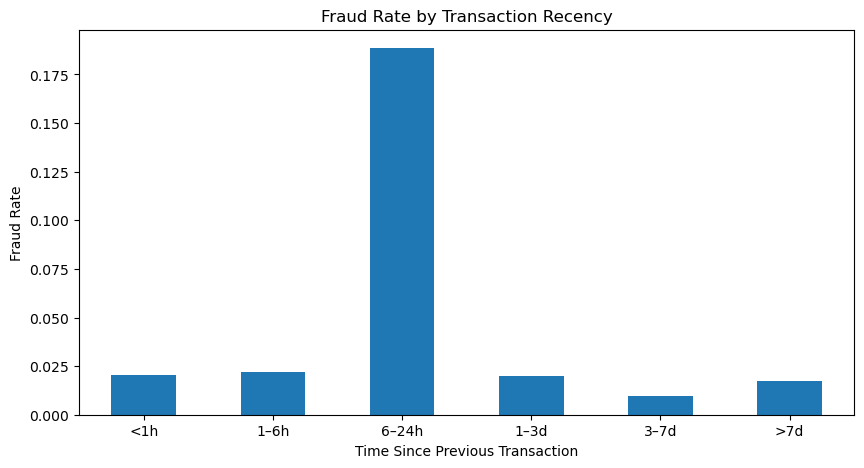

In [25]:
# --- Visualise fraud rate by recency bucket ---

plt.figure(figsize=(10, 5))
fraud_rate_by_recency.plot(kind="bar")

plt.title("Fraud Rate by Transaction Recency")
plt.xlabel("Time Since Previous Transaction")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=0)
plt.show()


---
## Week 2 · Day 1 — Baseline Models



In [1]:
# =========================
# 1) Imports & config
# =========================

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
)

# --- Optional: SHAP (can fail in some environments due to dependency issues) ---
SHAP_AVAILABLE = False
SHAP_IMPORT_ERROR = None

try:
    import shap  # noqa: F401
    SHAP_AVAILABLE = True
except Exception as e:
    SHAP_IMPORT_ERROR = e
    SHAP_AVAILABLE = False

print("SHAP available:", SHAP_AVAILABLE)
if not SHAP_AVAILABLE:
    print("SHAP import error (safe to ignore if you use the fallback section):", SHAP_IMPORT_ERROR)

C:\Users\caspe\anaconda\envs\genexa_ds\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SHAP available: True


## 2) Load dataset (cleaned from Week 1)

In [2]:
# =========================
# 2) Load dataset
# =========================

# Update this path to match your project structure
DATA_PATH = "../data/processed/cleaned_transactions.csv"

# Update if your time column has a different name (e.g., 'Date', 'transaction_time')
TIMESTAMP_COL = "timestamp"

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"Dataset not found at: {DATA_PATH}\n"
        "Fix: update DATA_PATH to the correct location of your cleaned dataset."
    )

df = pd.read_csv(DATA_PATH)

if TIMESTAMP_COL not in df.columns:
    raise KeyError(
        f"Expected a time column named '{TIMESTAMP_COL}' but it was not found.\n"
        f"Available columns: {list(df.columns)[:30]} ...\n"
        "Fix: set TIMESTAMP_COL to your actual time column name."
    )

# Parse timestamp and sort chronologically (critical for fraud problems)
df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL], errors="coerce")
df = df.dropna(subset=[TIMESTAMP_COL]).sort_values(TIMESTAMP_COL).reset_index(drop=True)

df.head()

,transaction_id,customer_id,timestamp,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,fee,...,account_age_days,device_trust_score,chargeback_history_count,risk_score_internal,txn_velocity_1h,txn_velocity_24h,corridor_risk,is_fraud,amount_src_num,amount_usd_num
0,fee8542d-8ee6-4b0d-9671-c294dd08ed26,402cccc9-28de-45b3-9af7-cc5302aa1f93,2022-10-03 18:40:59.468549+00:00,US,USD,CAD,ATM,278.19,278.19,4.25,...,263,0.522,0,0.223,0,0,0.0,0,278.19,278.19
1,bfdb9fc1-27fe-4a85-b043-4d813d679259,67c2c6b3-ef0a-4777-a3f1-c84a851bb6ad,2022-10-03 20:39:38.468549+00:00,CA,CAD,MXN,web,208.51,154.29,4.24,...,947,0.475,0,0.268,0,1,0.0,0,208.51,154.29
2,fc855034-3ea5-4993-9afa-b511d93fe5e8,6d0d9b27-fa26-45f8-93b1-2df29d182d9c,2022-10-03 23:02:43.468549+00:00,US,USD,CNY,mobile,160.33,160.33,2.70,...,367,0.939,0,0.176,0,0,0.0,0,160.33,160.33
3,2cf8c08e-42ec-444d-a755-34b9a2a0a4ca,7bd5200c-5d19-44f0-9afe-8b339a05366b,2022-10-04 01:08:53.468549+00:00,US,USD,EUR,mobile,59.41,59.41,2.22,...,147,0.551,0,0.391,0,0,0.0,0,59.41,59.41
4,d907a74d-b426-438d-97eb-dbe911aca91c,70a93d26-8e3a-4179-900c-a4a7a74d08e5,2022-10-04 09:35:03.468549+00:00,US,USD,INR,mobile,200.96,200.96,3.61,...,257,0.894,0,0.257,0,0,0.0,0,200.96,200.96


## 3) Quick sanity checks / light cleanup

In [3]:
# =========================
# 3) Light cleanup (safe)
# =========================

# Example: some Week 1 pipelines create helper columns you don't want in modelling.
# Drop only if it exists (prevents KeyError).
if "amount_src" in df.columns:
    df = df.drop(columns=["amount_src"])

print("Rows:", len(df))
print("Columns:", len(df.columns))

Rows: 11040
Columns: 27


## 4) Define target + feature columns

In [4]:
# =========================
# 4) Define target and features
# =========================

TARGET_COL = "is_fraud"

# Columns that should NOT be used as features (IDs / identifiers / raw timestamp)
id_cols = ["transaction_id", "customer_id", "ip_address", "device_id"]
time_cols = [TIMESTAMP_COL]

cols_to_exclude = set(id_cols + time_cols + [TARGET_COL])

missing_target = TARGET_COL not in df.columns
if missing_target:
    raise KeyError(
        f"Target column '{TARGET_COL}' not found.\n"
        "Fix: update TARGET_COL to match your label column (e.g., 'Class', 'fraud_label')."
    )

# Numeric features (exclude target)
numeric_features = (
    df.select_dtypes(include=["number"])
      .columns
      .difference([TARGET_COL])
      .tolist()
)

# Categorical/bool features (exclude IDs, time, target)
categorical_features = (
    df.select_dtypes(include=["object", "category", "bool"])
      .columns
      .difference(list(cols_to_exclude))
      .tolist()
)

print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))

Numeric features: 13
Categorical features: 8


In [5]:
# =========================
# 5) Build X and y
# =========================

feature_cols = numeric_features + categorical_features

X = df[feature_cols]
y = df[TARGET_COL].astype(int)

print("X shape:", X.shape)
print("y positive rate (fraud prevalence):", y.mean())

X shape: (11040, 21)
y positive rate (fraud prevalence): 0.08958333333333333


## 5) Time-based train/test split (NO SHUFFLE)

In [6]:
# =========================
# 6) Time-based split
# =========================

# df is already sorted by time
n_rows = len(df)
split_index = int(n_rows * 0.8)

X_train_raw = X.iloc[:split_index].copy()
y_train = y.iloc[:split_index].copy()

X_test_raw = X.iloc[split_index:].copy()
y_test = y.iloc[split_index:].copy()

print("Train:", X_train_raw.shape, "Test:", X_test_raw.shape)
print("Train fraud rate:", y_train.mean(), "Test fraud rate:", y_test.mean())

Train: (8832, 21) Test: (2208, 21)
Train fraud rate: 0.07676630434782608 Test fraud rate: 0.1408514492753623


## 6) Preprocessing (impute + scale + one-hot)

In [7]:
# =========================
# 7) Preprocessing
# =========================

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",
)

## 7) Evaluation helpers (threshold-aware)

In [8]:
# =========================
# 8) Evaluation helper
# =========================

def evaluate_model(model_name: str, y_true, y_proba, threshold: float = 0.5):
    """Evaluate a binary classifier at a given probability threshold."""
    y_pred = (y_proba >= threshold).astype(int)

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc = roc_auc_score(y_true, y_proba)

    print(f"=== {model_name} ===")
    print(f"Threshold : {threshold}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1-score  : {f1:.4f}")
    print(f"ROC-AUC   : {roc:.4f}")
    print()

    return {
        "model": model_name,
        "threshold": threshold,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc,
    }

## 8) Baseline model 1: Logistic Regression

In [9]:
# =========================
# 9) Logistic Regression baseline
# =========================

log_reg_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",  # helpful for imbalance baseline
        n_jobs=-1,
        random_state=42
    )),
])

log_reg_pipeline.fit(X_train_raw, y_train)

y_proba_lr = log_reg_pipeline.predict_proba(X_test_raw)[:, 1]

lr_results = evaluate_model(
    "Logistic Regression (baseline)",
    y_test,
    y_proba_lr,
    threshold=0.5
)

print("Classification report (threshold=0.5):")
print(classification_report(y_test, (y_proba_lr >= 0.5).astype(int), zero_division=0))

=== Logistic Regression (baseline) ===
Threshold : 0.5
Precision : 0.7787
Recall    : 0.9389
F1-score  : 0.8513
ROC-AUC   : 0.9802

Classification report (threshold=0.5):
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1897
           1       0.78      0.94      0.85       311

    accuracy                           0.95      2208
   macro avg       0.88      0.95      0.91      2208
weighted avg       0.96      0.95      0.96      2208



C:\Users\caspe\anaconda\envs\genexa_ds\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


## 9) Baseline model 2: Random Forest

In [10]:
# =========================
# 10) Random Forest baseline
# =========================

rf_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight="balanced_subsample",
        random_state=42,
        n_jobs=-1,
    )),
])

rf_pipeline.fit(X_train_raw, y_train)

y_proba_rf = rf_pipeline.predict_proba(X_test_raw)[:, 1]

rf_results = evaluate_model(
    "Random Forest (baseline)",
    y_test,
    y_proba_rf,
    threshold=0.5
)

print("Classification report (threshold=0.5):")
print(classification_report(y_test, (y_proba_rf >= 0.5).astype(int), zero_division=0))

=== Random Forest (baseline) ===
Threshold : 0.5
Precision : 0.9965
Recall    : 0.9164
F1-score  : 0.9548
ROC-AUC   : 0.9741

Classification report (threshold=0.5):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1897
           1       1.00      0.92      0.95       311

    accuracy                           0.99      2208
   macro avg       0.99      0.96      0.97      2208
weighted avg       0.99      0.99      0.99      2208



## 10) Compare baseline performance

In [11]:
baseline_results = pd.DataFrame([lr_results, rf_results])
baseline_results

,model,threshold,precision,recall,f1,roc_auc
0,Logistic Regression (baseline),0.5,0.778667,0.938907,0.851312,0.980223
1,Random Forest (baseline),0.5,0.996503,0.916399,0.954774,0.974060


## 11) Threshold exploration (why 0.5 is not “the default” in fraud)

**Lower threshold** → flag more transactions → usually **higher recall** but **lower precision**  
**Higher threshold** → flag fewer transactions → usually **higher precision** but **lower recall**

In [12]:
# Logistic Regression thresholds
lr_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
lr_threshold_results = [evaluate_model("LogReg", y_test, y_proba_lr, t) for t in lr_thresholds]
lr_threshold_df = pd.DataFrame(lr_threshold_results)

# Random Forest thresholds
rf_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
rf_threshold_results = [evaluate_model("RF", y_test, y_proba_rf, t) for t in rf_thresholds]
rf_threshold_df = pd.DataFrame(rf_threshold_results)

display(lr_threshold_df)
display(rf_threshold_df)

=== LogReg ===
Threshold : 0.1
Precision : 0.2329
Recall    : 0.9871
F1-score  : 0.3769
ROC-AUC   : 0.9802

=== LogReg ===
Threshold : 0.2
Precision : 0.3567
Recall    : 0.9807
F1-score  : 0.5232
ROC-AUC   : 0.9802

=== LogReg ===
Threshold : 0.3
Precision : 0.4942
Recall    : 0.9646
F1-score  : 0.6536
ROC-AUC   : 0.9802

=== LogReg ===
Threshold : 0.4
Precision : 0.6497
Recall    : 0.9421
F1-score  : 0.7690
ROC-AUC   : 0.9802

=== LogReg ===
Threshold : 0.5
Precision : 0.7787
Recall    : 0.9389
F1-score  : 0.8513
ROC-AUC   : 0.9802

=== RF ===
Threshold : 0.1
Precision : 0.5122
Recall    : 0.9486
F1-score  : 0.6652
ROC-AUC   : 0.9741

=== RF ===
Threshold : 0.2
Precision : 0.7880
Recall    : 0.9325
F1-score  : 0.8542
ROC-AUC   : 0.9741

=== RF ===
Threshold : 0.3
Precision : 0.9258
Recall    : 0.9228
F1-score  : 0.9243
ROC-AUC   : 0.9741

=== RF ===
Threshold : 0.4
Precision : 0.9862
Recall    : 0.9164
F1-score  : 0.9500
ROC-AUC   : 0.9741

=== RF ===
Threshold : 0.5
Precision : 0.996

,model,threshold,precision,recall,f1,roc_auc
0,LogReg,0.1,0.232929,0.987138,0.376918,0.980223
1,LogReg,0.2,0.356725,0.980707,0.523156,0.980223
2,LogReg,0.3,0.494234,0.964630,0.653595,0.980223
3,LogReg,0.4,0.649667,0.942122,0.769029,0.980223
4,LogReg,0.5,0.778667,0.938907,0.851312,0.980223


,model,threshold,precision,recall,f1,roc_auc
0,RF,0.1,0.512153,0.948553,0.665163,0.97406
1,RF,0.2,0.788043,0.932476,0.854197,0.97406
2,RF,0.3,0.925806,0.922830,0.924316,0.97406
3,RF,0.4,0.986159,0.916399,0.950000,0.97406
4,RF,0.5,0.996503,0.916399,0.954774,0.97406


## 12) Precision–Recall curves (best for imbalanced fraud problems)

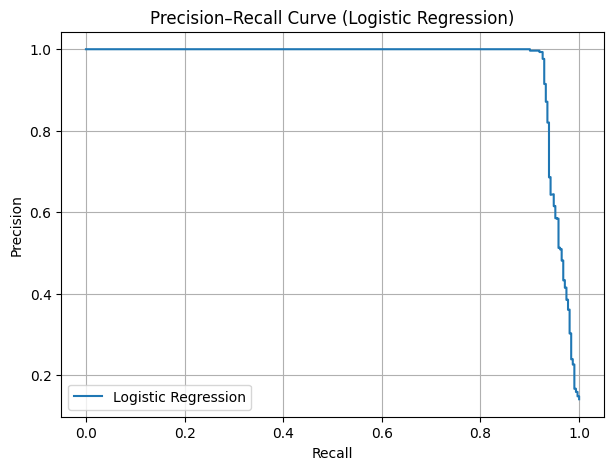

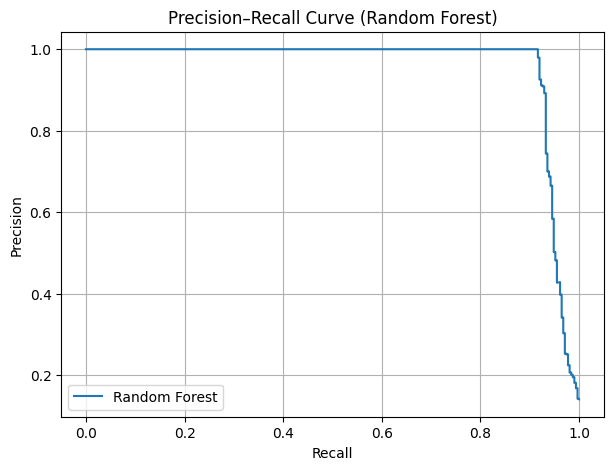

In [13]:
# Logistic Regression PR curve
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_proba_lr)

plt.figure(figsize=(7, 5))
plt.plot(recall_lr, precision_lr, label="Logistic Regression")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Logistic Regression)")
plt.grid(True)
plt.legend()
plt.show()

# Random Forest PR curve
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_proba_rf)

plt.figure(figsize=(7, 5))
plt.plot(recall_rf, precision_rf, label="Random Forest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Random Forest)")
plt.grid(True)
plt.legend()
plt.show()

## 13) Explainability (SHAP if available, fallback if not)

SHAP: Logistic Regression (beeswarm + bar)


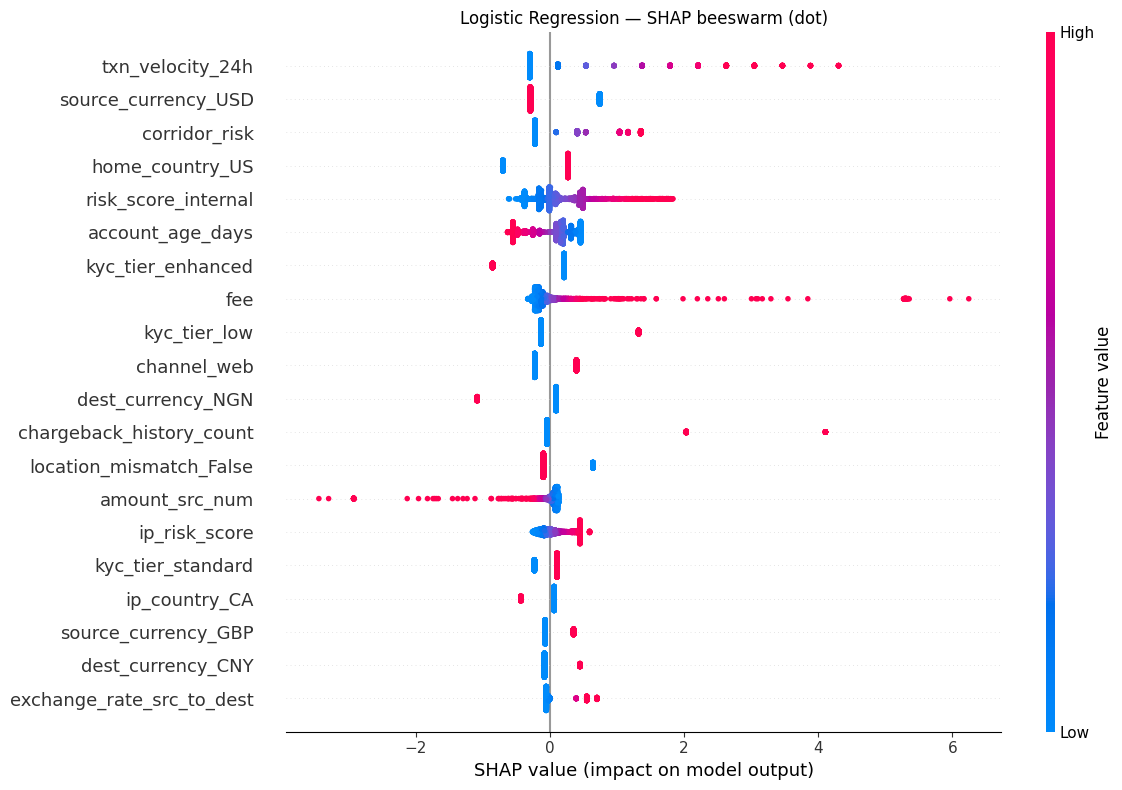

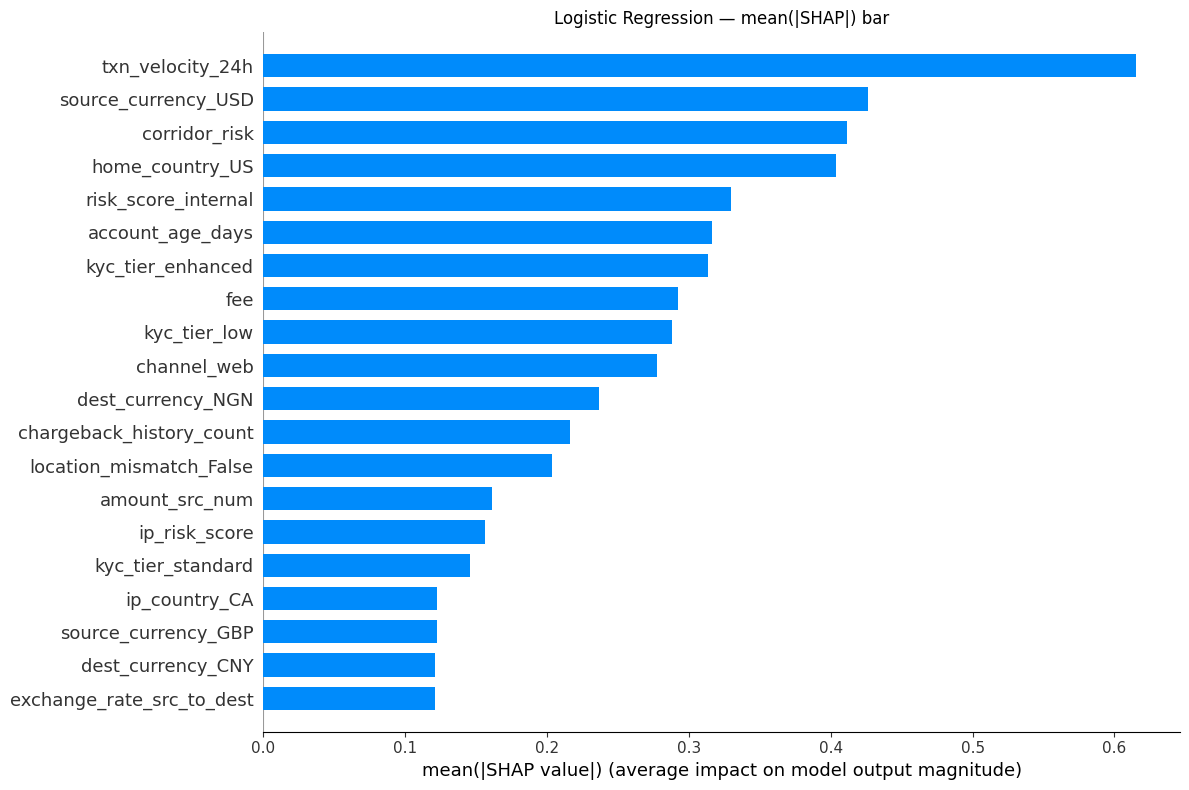

In [19]:
# =========================
# 11) Explainability
# =========================

if SHAP_AVAILABLE:
    import shap
    shap.initjs()

    # Use the fitted preprocessor from the pipeline (safer than relying on a standalone variable)
    fitted_preprocessor = rf_pipeline.named_steps["preprocess"]

    # --- Build feature names after preprocessing ---
    numeric_feature_names = list(numeric_features)
    categorical_feature_names = (
        fitted_preprocessor
        .named_transformers_["cat"]
        .named_steps["encoder"]
        .get_feature_names_out(categorical_features)
        .tolist()
    )
    feature_names = numeric_feature_names + categorical_feature_names

    # Transform data for SHAP (model expects transformed inputs)
    X_train_trans = fitted_preprocessor.transform(X_train_raw)
    X_test_trans  = fitted_preprocessor.transform(X_test_raw)

    X_train_df = pd.DataFrame(X_train_trans, columns=feature_names)
    X_test_df  = pd.DataFrame(X_test_trans, columns=feature_names)

    # Helper: make sure we ALWAYS plot full labels nicely
    def _show_shap_plot(title: str, save_path: str | None = None):
        plt.title(title)
        plt.gcf().set_size_inches(12, 8)   # bigger canvas so labels show fully
        plt.tight_layout()
        if save_path is not None:
            plt.savefig(save_path, dpi=200, bbox_inches="tight")
        plt.show()

    # ---- Logistic Regression SHAP ----
    print("SHAP: Logistic Regression (beeswarm + bar)")
    lr_model = log_reg_pipeline.named_steps["model"]

    # LinearExplainer expects the same feature space as the model (transformed space)
    explainer_lr = shap.LinearExplainer(lr_model, X_train_df)
    shap_values_lr = explainer_lr.shap_values(X_test_df)  # 2D array (n_samples, n_features)

    # ✅ Beeswarm / dot plot (like your previous project screenshot)
    shap.summary_plot(shap_values_lr, X_test_df, plot_type="dot", max_display=20, show=False)
    _show_shap_plot("Logistic Regression — SHAP beeswarm (dot)")

    # ✅ Bar plot (mean(|SHAP|)) — optional but useful for quick ranking
    shap.summary_plot(shap_values_lr, X_test_df, plot_type="bar", max_display=20, show=False)
    _show_shap_plot("Logistic Regression — mean(|SHAP|) bar")




SHAP: Random Forest (beeswarm)
RF SHAP values ndim: 3 shape: (2208, 71, 2)


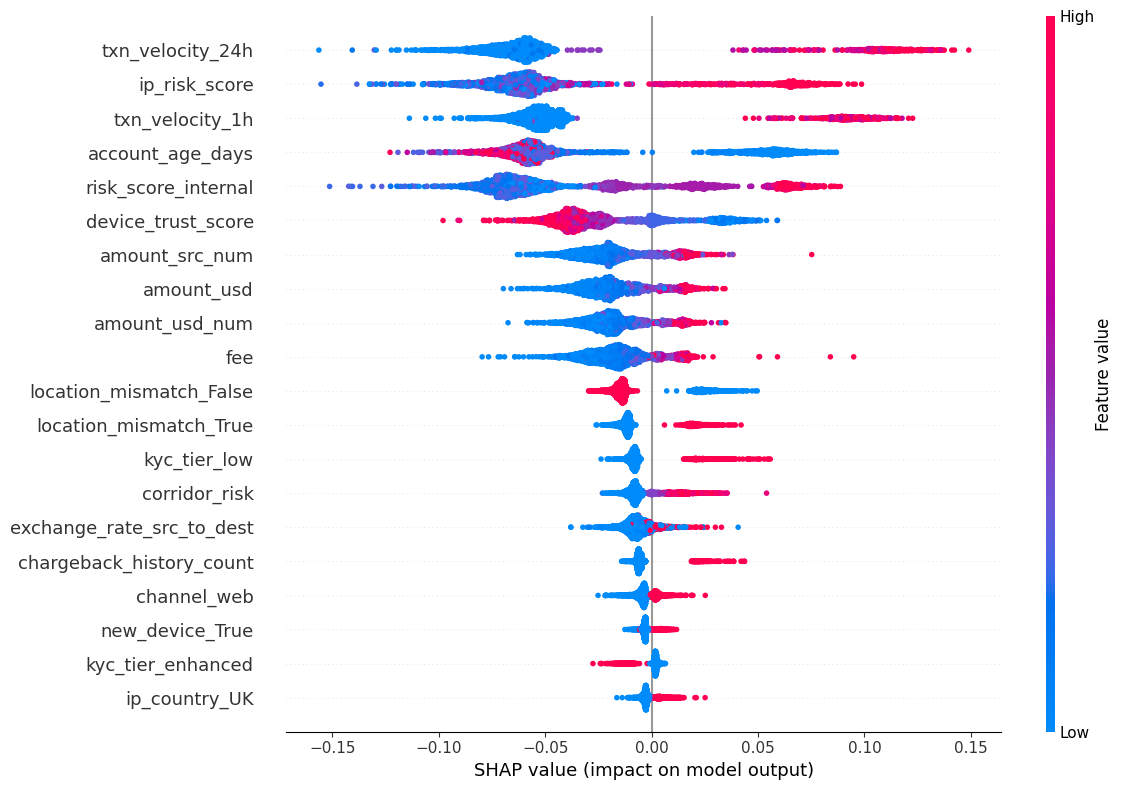

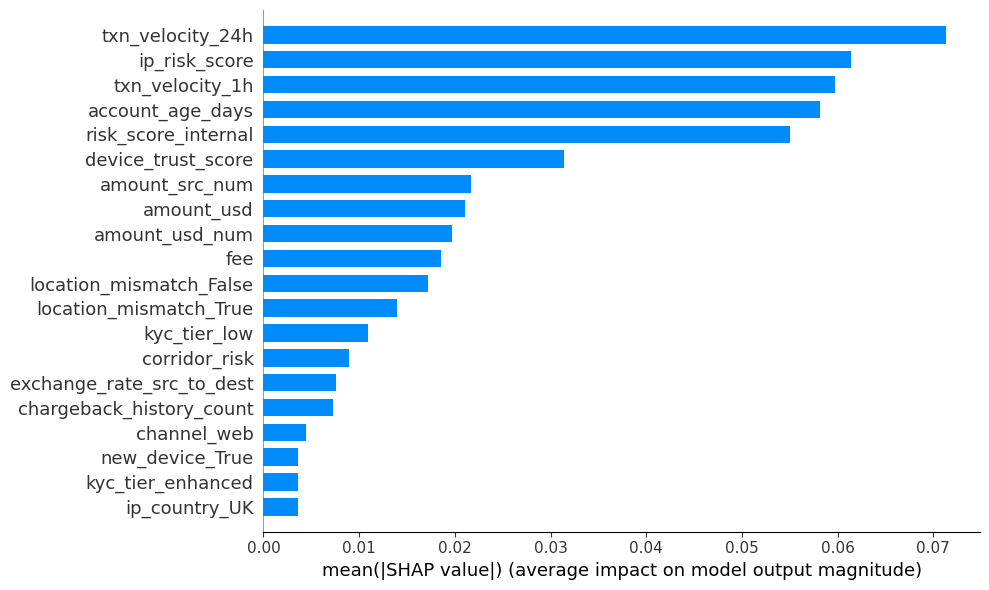

In [18]:
if SHAP_AVAILABLE:
    import shap
    import numpy as np
    import matplotlib.pyplot as plt

    shap.initjs()

    # Use the fitted preprocessor from the pipeline (safer)
    fitted_preprocess = rf_pipeline.named_steps["preprocess"]

    # --- Build feature names after preprocessing ---
    numeric_feature_names = list(numeric_features)
    categorical_feature_names = (
        fitted_preprocess
        .named_transformers_["cat"]
        .named_steps["encoder"]
        .get_feature_names_out(categorical_features)
        .tolist()
    )
    feature_names = numeric_feature_names + categorical_feature_names

    # Transform data for SHAP (the RF model expects transformed inputs)
    X_train_trans = fitted_preprocess.transform(X_train_raw)
    X_test_trans  = fitted_preprocess.transform(X_test_raw)

    X_train_df = pd.DataFrame(X_train_trans, columns=feature_names)
    X_test_df  = pd.DataFrame(X_test_trans,  columns=feature_names)

    # ---- Random Forest SHAP (beeswarm + bar) ----
    print("SHAP: Random Forest (beeswarm)")
    rf_model = rf_pipeline.named_steps["model"]
    explainer_rf = shap.TreeExplainer(rf_model)
    shap_values_rf = explainer_rf.shap_values(X_test_df)

    # For binary classification, shap may return:
    # 1) a list [class0, class1] each (n_samples, n_features)
    # 2) a single array (n_samples, n_features)
    # 3) sometimes a single array (n_samples, n_features, 2) -> multi-output style (rare)
    if isinstance(shap_values_rf, list):
        shap_vals_rf = shap_values_rf[1]  # class 1 (fraud)
    else:
        shap_vals_rf = shap_values_rf

    arr = np.array(shap_vals_rf)
    print("RF SHAP values ndim:", arr.ndim, "shape:", arr.shape)

    # Handle the common 3D binary-output shape (n, p, 2) safely
    if arr.ndim == 3 and arr.shape[-1] == 2:
        shap_vals_rf = arr[:, :, 1]  # take class 1 (fraud)
        arr = np.array(shap_vals_rf)

    # If it's still 3D and square on the last two dims, it's interaction values (n, p, p)
    if arr.ndim == 3 and arr.shape[1] == arr.shape[2]:
        raise ValueError(
            "You're passing SHAP *interaction* values into summary_plot (shape looks like n x p x p). "
            "Fix: make sure you're using explainer_rf.shap_values(...) NOT explainer_rf.shap_interaction_values(...). "
            "Search your notebook for 'shap_interaction_values' and remove it."
        )

    # At this point we expect a 2D matrix (n_samples, n_features)
    if np.array(shap_vals_rf).ndim != 2:
        raise ValueError(
            "Random Forest SHAP values are not 2D after cleanup. "
            "Paste the printed shape above and we'll handle that specific case."
        )

    # ✅ Beeswarm (dot) plot — like your preferred style
    shap.summary_plot(shap_vals_rf, X_test_df, plot_type="dot", max_display=20, show=False)
    plt.gcf().set_size_inches(12, 8)   # prevents label cutoff
    plt.tight_layout()
    plt.show()

    # ✅ Bar plot (mean |SHAP|) — optional global importance
    shap.summary_plot(shap_vals_rf, X_test_df, plot_type="bar", max_display=20, show=False)
    plt.gcf().set_size_inches(10, 6)
    plt.tight_layout()
    plt.show()

else:
    print("SHAP is not available in this environment.")
    print("Fallback explainability: use permutation importance (already included earlier).")

## 14) Reflection: choose a threshold

Use the threshold tables + PR curves to answer:

**Which probability threshold gives the best balance between recall and precision for your use case?**

Tip: In fraud, many teams prioritize **recall** (catch fraud) but must control false positives (precision).


---
## Week 2 · Day 3 — Advanced Modeling & Imbalance Handling



In [4]:
import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Imbalance tools
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

RANDOM_STATE = 42

# ---- Load your processed dataset ----
DATA_PATH = "../data/processed/cleaned_transactions.csv"
TIMESTAMP_COL = "timestamp"
TARGET_COL = "is_fraud"

df = pd.read_csv(DATA_PATH)
df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL], errors="coerce")
df = df.dropna(subset=[TIMESTAMP_COL]).sort_values(TIMESTAMP_COL).reset_index(drop=True)

# ---- Feature groups ----
numeric_features = (
    df.select_dtypes(include=["number"])
      .columns
      .drop([TARGET_COL], errors="ignore")
      .tolist()
)
categorical_features = (
    df.select_dtypes(include=["object", "category", "bool"])
      .columns
      .drop([TARGET_COL, TIMESTAMP_COL], errors="ignore")
      .tolist()
)

X = df[numeric_features + categorical_features]
y = df[TARGET_COL].astype(int)

# ---- Time split (same approach as Day 1) ----
split_index = int(len(df) * 0.8)
X_train_raw, X_test_raw = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print("Train shape:", X_train_raw.shape, "Test shape:", X_test_raw.shape)
print("Train fraud rate:", y_train.mean(), "Test fraud rate:", y_test.mean())

# ---- Preprocessing ----
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
], remainder="drop")


# ---- Experiment logger ----
def evaluate_probs(y_true, y_proba, threshold=0.5):
    y_pred = (y_proba >= threshold).astype(int)
    return {
        "threshold": threshold,
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_proba)
    }

experiment_log = []

Train shape: (8832, 26) Test shape: (2208, 26)
Train fraud rate: 0.07676630434782608 Test fraud rate: 0.1408514492753623


In [6]:
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
print("imblearn version:", imblearn.__version__)

imblearn version: 0.11.0


In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve

def eval_at_threshold(y_true, y_proba, threshold=0.5):
    y_pred = (y_proba >= threshold).astype(int)
    return {
        "threshold": threshold,
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_proba),
    }

experiment_log = []

def log_result(model_name, imbalance_method, y_true, y_proba, threshold=0.5, notes=""):
    row = {
        "model": model_name,
        "imbalance_method": imbalance_method,
        **eval_at_threshold(y_true, y_proba, threshold),
        "notes": notes
    }

    # remove any existing row with same model + method + threshold
    global experiment_log
    experiment_log = [
        r for r in experiment_log
        if not (r["model"] == model_name and r["imbalance_method"] == imbalance_method and r["threshold"] == threshold)
    ]

    experiment_log.append(row)
    return row

## Random Forest + Random UnderSampling (Imbalance Handling)

### Why are we doing this?
Fraud datasets are imbalanced (few fraud cases, many legitimate cases). Many models become biased toward predicting “legit” because that’s the majority class.

**RandomUnderSampler** reduces the number of legitimate transactions in the training set so the model sees a more balanced dataset during learning.  
This often improves **recall** (catching more fraud), but it can sometimes reduce **precision** (more false alarms).

### What this experiment does
1. Applies the same preprocessing pipeline (scaling numeric + encoding categorical).
2. Undersamples the majority class (legit) **only on the training data**.
3. Trains a Random Forest model.
4. Predicts fraud probabilities on the test set.
5. Evaluates precision, recall, F1, and ROC-AUC at a chosen threshold (0.5).
6. Logs the results into our experiment tracker.

In [13]:
# =========================
# Random Forest + UnderSampling (Imbalance Handling)
# =========================

# 1) Import the model and imbalance tool
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# 2) Build an imbalanced-learn pipeline
#    Why ImbPipeline?
#    - It allows sampling steps (like RandomUnderSampler) inside a pipeline
#    - It ensures the sampler runs ONLY during training (fit), not during predict
rf_under = ImbPipeline(steps=[
    ("preprocess", preprocess),  # (a) apply preprocessing: impute + scale + one-hot encode
    ("under", RandomUnderSampler(random_state=42)),  # (b) undersample majority class in TRAIN only
    ("model", RandomForestClassifier(
        n_estimators=300,      # number of trees (more trees = more stable, but slower)
        random_state=42,       # for reproducibility
        n_jobs=-1              # use all CPU cores
    ))
])

# 3) Train the pipeline on the training split
rf_under.fit(X_train_raw, y_train)

# 4) Predict probabilities on the test split
#    We take [:, 1] because column 1 is the probability of class 1 (fraud)
y_proba = rf_under.predict_proba(X_test_raw)[:, 1]

# 5) Log results (evaluated at threshold=0.5)
#    This stores metrics in your experiment_log list so we can compare many runs later
log_result(
    model_name="RandomForest",
    imbalance_method="RandomUnderSampler",
    y_true=y_test,
    y_proba=y_proba,
    threshold=0.5,
    notes="Baseline RF + undersampling"
)

# 6) Display experiment results sorted by best F1 score
pd.DataFrame(experiment_log).sort_values("f1", ascending=False)

,model,imbalance_method,threshold,precision,recall,f1,roc_auc,notes
0,RandomForest,RandomUnderSampler,0.5,0.903427,0.932476,0.917722,0.978038,Baseline RF + undersampling


## Random Forest + SMOTE (Oversampling the Minority Class)

### Why SMOTE?
Undersampling throws away many legitimate transactions, which can remove useful patterns.
**SMOTE** (Synthetic Minority Oversampling Technique) instead *adds* synthetic fraud samples to the training set, making the classes more balanced **without deleting majority-class data**.

### What this experiment does
1. Preprocess the data (impute + scale + one-hot encode).
2. Apply SMOTE **on the training data only** to generate additional fraud-like samples.
3. Train a Random Forest model on the SMOTE-balanced training data.
4. Predict fraud probabilities on the untouched test set.
5. Evaluate and log performance (precision, recall, F1, ROC-AUC).

In [14]:
# =========================
# Random Forest + SMOTE (Imbalance Handling)
# =========================

from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# NOTE:
# SMOTE creates synthetic minority samples by looking at nearest neighbors.
# It works best on numeric feature spaces. Since we one-hot encode categoricals,
# SMOTE can still run, but it's not always ideal for one-hot encoded data.
# For today (Day 3), it's still a valid experiment. Later, we can consider SMOTENC.

rf_smote = ImbPipeline(steps=[
    ("preprocess", preprocess),                 # (a) preprocessing
    ("smote", SMOTE(random_state=42)),          # (b) oversample fraud class in TRAIN only
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

# Train
rf_smote.fit(X_train_raw, y_train)

# Predict probabilities on TEST
y_proba = rf_smote.predict_proba(X_test_raw)[:, 1]

# Log results
log_result(
    model_name="RandomForest",
    imbalance_method="SMOTE",
    y_true=y_test,
    y_proba=y_proba,
    threshold=0.5,
    notes="RF + SMOTE oversampling"
)

# View results
pd.DataFrame(experiment_log).sort_values("f1", ascending=False)

,model,imbalance_method,threshold,precision,recall,f1,roc_auc,notes
1,RandomForest,SMOTE,0.5,1.000000,0.916399,0.956376,0.971303,RF + SMOTE oversampling
0,RandomForest,RandomUnderSampler,0.5,0.903427,0.932476,0.917722,0.978038,Baseline RF + undersampling


## Random Forest + Class Weights (No Sampling)

### Why this approach?
Instead of changing the dataset size (undersampling) or generating synthetic samples (SMOTE),
we tell the model that fraud errors are more costly by using **class_weight**.

This often improves recall while keeping the dataset intact.

### What this experiment does
1. Preprocess data (impute + scale + one-hot encode)
2. Train a Random Forest with class weighting
3. Predict probabilities on the test set
4. Evaluate precision/recall/F1/ROC-AUC and log results

In [15]:
# =========================
# Random Forest + Class Weights (No Sampling)
# =========================

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

rf_weighted = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced_subsample"  # balances classes per tree sample
    ))
])

# Train
rf_weighted.fit(X_train_raw, y_train)

# Predict probabilities
y_proba = rf_weighted.predict_proba(X_test_raw)[:, 1]

# Log results
log_result(
    model_name="RandomForest",
    imbalance_method="class_weight=balanced_subsample",
    y_true=y_test,
    y_proba=y_proba,
    threshold=0.5,
    notes="RF without sampling; uses class weights"
)

# View log (latest runs only)
pd.DataFrame(experiment_log).sort_values("f1", ascending=False)

,model,imbalance_method,threshold,precision,recall,f1,roc_auc,notes
1,RandomForest,SMOTE,0.5,1.000000,0.916399,0.956376,0.971303,RF + SMOTE oversampling
2,RandomForest,class_weight=balanced_subsample,0.5,1.000000,0.916399,0.956376,0.974102,RF without sampling; uses class weights
0,RandomForest,RandomUnderSampler,0.5,0.903427,0.932476,0.917722,0.978038,Baseline RF + undersampling


In [ ]:
# pip install lightgbm

  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
Using cached lightgbm-4.6.0-py3-none-win_amd64.whl (1.5 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import importlib

for pkg in ["xgboost", "lightgbm"]:
    try:
        importlib.import_module(pkg)
        print(f"✅ {pkg} is installed")
    except Exception as e:
        print(f"❌ {pkg} not installed -> {e}")

✅ xgboost is installed
✅ lightgbm is installed


## XGBoost (Advanced Model) + Imbalance Handling

### Why XGBoost?
XGBoost is a strong gradient-boosting model that often outperforms bagging models (like Random Forest)
on structured/tabular datasets.

### How we handle imbalance in XGBoost
Instead of SMOTE/undersampling, XGBoost can directly weight the minority class using:

**scale_pos_weight = (#negative / #positive)**

This tells the model that fraud errors are more costly and often improves recall.

In [17]:
from xgboost import XGBClassifier

# 1) Compute scale_pos_weight from training set
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos
print("scale_pos_weight:", scale_pos_weight)

# 2) XGBoost pipeline (uses same preprocessing)
xgb_weighted = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", XGBClassifier(
        n_estimators=500,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss",
        scale_pos_weight=scale_pos_weight
    ))
])

# 3) Train
xgb_weighted.fit(X_train_raw, y_train)

# 4) Predict probabilities (fraud class)
y_proba = xgb_weighted.predict_proba(X_test_raw)[:, 1]

# 5) Log results
log_result(
    model_name="XGBoost",
    imbalance_method=f"scale_pos_weight={scale_pos_weight:.2f}",
    y_true=y_test,
    y_proba=y_proba,
    threshold=0.5,
    notes="XGB with class weighting (no sampling)"
)

pd.DataFrame(experiment_log).sort_values("f1", ascending=False)

scale_pos_weight: 12.026548672566372


,model,imbalance_method,threshold,precision,recall,f1,roc_auc,notes
1,RandomForest,SMOTE,0.5,1.000000,0.916399,0.956376,0.971303,RF + SMOTE oversampling
2,RandomForest,class_weight=balanced_subsample,0.5,1.000000,0.916399,0.956376,0.974102,RF without sampling; uses class weights
0,RandomForest,RandomUnderSampler,0.5,0.903427,0.932476,0.917722,0.978038,Baseline RF + undersampling
3,XGBoost,scale_pos_weight=12.03,0.5,0.899371,0.919614,0.909380,0.975314,XGB with class weighting (no sampling)


In [20]:
xgb_t07 = eval_at_threshold(y_test, y_proba, threshold=0.7)
xgb_t07

{'threshold': 0.7,
 'precision': 0.9827586206896551,
 'recall': 0.9163987138263665,
 'f1': 0.9484193011647254,
 'roc_auc': 0.9753138734878392}

In [21]:
thresholds = np.round(np.arange(0.1, 0.8, 0.1), 1)  # 0.1 to 0.7

rows = []
for t in thresholds:
    m = eval_at_threshold(y_test, y_proba, threshold=float(t))
    rows.append({
        "model": "XGBoost",
        "imbalance_method": f"scale_pos_weight={scale_pos_weight:.2f}",
        "threshold": float(t),
        "precision": m["precision"],
        "recall": m["recall"],
        "f1": m["f1"],
        "roc_auc": m["roc_auc"],
    })

xgb_threshold_df = pd.DataFrame(rows).sort_values("f1", ascending=False)
xgb_threshold_df

,model,imbalance_method,threshold,precision,recall,f1,roc_auc
6,XGBoost,scale_pos_weight=12.03,0.7,0.982759,0.916399,0.948419,0.975314
5,XGBoost,scale_pos_weight=12.03,0.6,0.937705,0.919614,0.928571,0.975314
4,XGBoost,scale_pos_weight=12.03,0.5,0.899371,0.919614,0.909380,0.975314
3,XGBoost,scale_pos_weight=12.03,0.4,0.857567,0.929260,0.891975,0.975314
2,XGBoost,scale_pos_weight=12.03,0.3,0.776596,0.938907,0.850073,0.975314
1,XGBoost,scale_pos_weight=12.03,0.2,0.653422,0.951768,0.774869,0.975314
0,XGBoost,scale_pos_weight=12.03,0.1,0.473016,0.958199,0.633369,0.975314


## LightGBM (Advanced Model) + Imbalance Handling

### Why LightGBM?
LightGBM is a fast gradient-boosting model (like XGBoost) that often performs very well on tabular data.
It can handle imbalance using built-in weighting instead of resampling.

### Imbalance strategy used
We use **class_weight="balanced"** so the model penalizes mistakes on fraud (minority) more heavily.


In [22]:
from lightgbm import LGBMClassifier

lgbm_weighted = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LGBMClassifier(
        n_estimators=800,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"   # imbalance handling
    ))
])

# Train
lgbm_weighted.fit(X_train_raw, y_train)

# Predict probabilities
y_proba = lgbm_weighted.predict_proba(X_test_raw)[:, 1]

# Log
log_result(
    model_name="LightGBM",
    imbalance_method="class_weight=balanced",
    y_true=y_test,
    y_proba=y_proba,
    threshold=0.5,
    notes="LGBM with class weighting (no sampling)"
)

pd.DataFrame(experiment_log).sort_values("f1", ascending=False)

[LightGBM] [Info] Number of positive: 678, number of negative: 8154
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2396
[LightGBM] [Info] Number of data points in the train set: 8832, number of used features: 184
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


,model,imbalance_method,threshold,precision,recall,f1,roc_auc,notes
1,RandomForest,SMOTE,0.5,1.000000,0.916399,0.956376,0.971303,RF + SMOTE oversampling
2,RandomForest,class_weight=balanced_subsample,0.5,1.000000,0.916399,0.956376,0.974102,RF without sampling; uses class weights
4,LightGBM,class_weight=balanced,0.5,0.972696,0.916399,0.943709,0.966474,LGBM with class weighting (no sampling)
0,RandomForest,RandomUnderSampler,0.5,0.903427,0.932476,0.917722,0.978038,Baseline RF + undersampling
3,XGBoost,scale_pos_weight=12.03,0.5,0.899371,0.919614,0.909380,0.975314,XGB with class weighting (no sampling)


In [23]:
thresholds = np.round(np.arange(0.1, 0.8, 0.1), 1)

rows = []
for t in thresholds:
    m = eval_at_threshold(y_test, y_proba, threshold=float(t))  # y_proba from LightGBM
    rows.append({
        "model": "LightGBM",
        "imbalance_method": "class_weight=balanced",
        "threshold": float(t),
        "precision": m["precision"],
        "recall": m["recall"],
        "f1": m["f1"],
        "roc_auc": m["roc_auc"],
    })

lgbm_threshold_df = pd.DataFrame(rows).sort_values("f1", ascending=False)
lgbm_threshold_df

,model,imbalance_method,threshold,precision,recall,f1,roc_auc
6,LightGBM,class_weight=balanced,0.7,0.989583,0.916399,0.951586,0.966474
5,LightGBM,class_weight=balanced,0.6,0.982759,0.916399,0.948419,0.966474
4,LightGBM,class_weight=balanced,0.5,0.972696,0.916399,0.943709,0.966474
3,LightGBM,class_weight=balanced,0.4,0.969388,0.916399,0.942149,0.966474
2,LightGBM,class_weight=balanced,0.3,0.962838,0.916399,0.939044,0.966474
1,LightGBM,class_weight=balanced,0.2,0.946844,0.916399,0.931373,0.966474
0,LightGBM,class_weight=balanced,0.1,0.922330,0.916399,0.919355,0.966474


## Reflection (fraud prevalence over time & stability):
Fraud prevalence increased from the training period (7.7%) to the test period (14.1%), showing the distribution of the target changes over time. 
When prevalence shifts, a fixed threshold can produce different precision/recall behaviour because the base rate of fraud affects how many alerts the model generates and how many are true positives. This can make model performance less stable in production, especially precision, because more (or fewer) cases fall above the decision threshold depending on the time window. 

As a result, models should be validated on time-based splits and monitored continuously, with periodic threshold recalibration. Using imbalance-aware approaches (class weights, SMOTE, tuned thresholds) helps maintain recall while controlling false positives under changing fraud rates.


---
## Week 2 · Day 4 — Explainability & Stakeholder Interpretation



In [1]:
# =========================
# 1) Imports
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import shap

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

C:\Users\caspe\anaconda\envs\genexa_ds\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2) Load Data (Time-Ordered)
We keep the same time-based split used in prior days to mimic real-world deployment:
- Train = earlier transactions  
- Test  = later transactions  

This avoids leakage and allows us to test stability across time.

In [16]:
# -------------------------
# Config
# -------------------------
DATA_PATH = "../data/processed/cleaned_transactions.csv"
TIMESTAMP_COL = "timestamp"
TARGET_COL = "is_fraud"

# -------------------------
# Load
# -------------------------
df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.strip()

# Parse timestamp and sort
df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL], errors="coerce")
df = df.dropna(subset=[TIMESTAMP_COL]).sort_values(TIMESTAMP_COL).reset_index(drop=True)

# -------------------------
# Feature groups
# -------------------------
numeric_features = (
    df.select_dtypes(include=["number"])
      .columns
      .drop([TARGET_COL], errors="ignore")
      .tolist()
)

categorical_features = (
    df.select_dtypes(include=["object", "category", "bool"])
      .columns
      .drop([TARGET_COL, TIMESTAMP_COL], errors="ignore")
      .tolist()
)

# ✅ NEW: Remove identifier-like columns (high-cardinality, not stakeholder-friendly, can cause leakage)
ID_COLS = ["transaction_id", "customer_id", "device_id", "ip_address"]
categorical_features = [c for c in categorical_features if c not in ID_COLS]

# Build X/y
X = df[numeric_features + categorical_features]
y = df[TARGET_COL].astype(int)

# -------------------------
# Time split (80/20)
# -------------------------
split_index = int(len(df) * 0.8)
X_train_raw, X_test_raw = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print("Dropped ID columns:", ID_COLS)
print("Train shape:", X_train_raw.shape, "| Test shape:", X_test_raw.shape)
print("Train fraud rate:", round(y_train.mean(), 4), "| Test fraud rate:", round(y_test.mean(), 4))


Dropped ID columns: ['transaction_id', 'customer_id', 'device_id', 'ip_address']
Train shape: (8832, 22) | Test shape: (2208, 22)
Train fraud rate: 0.0768 | Test fraud rate: 0.1409


## 3) Train the Model to Explain (Reproducible)
This notebook is separate from Week 2 Day 3, so the trained model objects from that notebook are not available here.
To ensure reproducibility and transparency, we rebuild and refit the selected model pipeline in this notebook before generating explanations.


In [17]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
], remainder="drop")

## Evaluation helper (optional)
We use the same metric calculation so results are consistent with Day 3.

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

def eval_at_threshold(y_true, y_proba, threshold=0.5):
    y_pred = (y_proba >= threshold).astype(int)
    return {
        "threshold": threshold,
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_proba),
    }

## Train the model we will explain (RF + class weights)
We refit the chosen “best” model here so SHAP explanations are generated from an identical pipeline.


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

rf_weighted = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced_subsample"
    ))
])

rf_weighted.fit(X_train_raw, y_train)

MODEL_PIPELINE = rf_weighted
THRESHOLD = 0.5

print("Model ready:", MODEL_PIPELINE.named_steps["model"].__class__.__name__)

Model ready: RandomForestClassifier


## 4) SHAP Setup — Feature Names After Preprocessing
SHAP explanations must use the **same feature space** that the model was trained on.
Because our pipeline uses OneHotEncoder, we rebuild feature names after preprocessing.


In [19]:
def get_feature_names_from_preprocess(preprocess: ColumnTransformer, numeric_features, categorical_features):
    num_names = list(numeric_features)
    cat_encoder = preprocess.named_transformers_["cat"].named_steps["encoder"]
    cat_names = cat_encoder.get_feature_names_out(categorical_features).tolist()
    return num_names + cat_names


## 5) Build Transaction-Level SHAP Explainer (Local Explanations)
We explain individual transactions in a regulator-friendly way:
- show predicted **fraud probability** (confidence)
- show decision (FLAG/ALLOW) based on threshold
- show top SHAP contributors as **reason codes**


In [20]:
import shap
import numpy as np
import pandas as pd

def make_shap_for_tree_pipeline(trained_pipeline: Pipeline,
                               X_background_raw: pd.DataFrame,
                               X_explain_raw: pd.DataFrame,
                               numeric_features,
                               categorical_features):
    """
    Builds SHAP explanations for a tree model inside a preprocessing pipeline.

    Key improvements:
    - Removes additivity crash risk (check_additivity=False)
    - Uses interventional perturbation with a proper background dataset
    - Explains in probability space for stakeholder readability
    """
    preprocess = trained_pipeline.named_steps["preprocess"]
    model = trained_pipeline.named_steps["model"]

    feature_names = get_feature_names_from_preprocess(preprocess, numeric_features, categorical_features)

    # Transform background + explain rows into the SAME feature space
    X_bg = preprocess.transform(X_background_raw)
    X_ex = preprocess.transform(X_explain_raw)

    X_bg = X_bg.toarray() if hasattr(X_bg, "toarray") else X_bg
    X_ex = X_ex.toarray() if hasattr(X_ex, "toarray") else X_ex

    X_bg_df = pd.DataFrame(X_bg, columns=feature_names)
    X_ex_df = pd.DataFrame(X_ex, columns=feature_names)

    # ✅ Proper interventional setup + probability output
    explainer = shap.TreeExplainer(
        model,
        data=X_bg_df,
        feature_perturbation="interventional",
        model_output="probability"
    )

    shap_values = explainer.shap_values(X_ex_df, check_additivity=False)

    # Binary classifier output handling
    if isinstance(shap_values, list):
        shap_vals = shap_values[1]  # class 1 = fraud
    else:
        arr = np.array(shap_values)
        shap_vals = arr[:, :, 1] if (arr.ndim == 3 and arr.shape[-1] == 2) else arr

    # Guard against interaction values (n, p, p)
    arr2 = np.array(shap_vals)
    if arr2.ndim == 3 and arr2.shape[1] == arr2.shape[2]:
        raise ValueError("Interaction SHAP detected (n,p,p). Use shap_values, not shap_interaction_values.")

    return explainer, X_ex_df, shap_vals, feature_names

## 6) Analyst View — Convert SHAP into Reason Codes
This function produces a stakeholder-ready explanation for one transaction:
- Fraud probability
- Decision (FLAG/ALLOW)
- Top factors pushing toward fraud (**reason codes**)
- Top factors pushing away from fraud (why it might be legit)


In [21]:
import numpy as np
import pandas as pd

def analyst_view(trained_pipeline: Pipeline,
                 X_background_raw: pd.DataFrame,
                 X_row_raw: pd.DataFrame,
                 numeric_features,
                 categorical_features,
                 threshold=0.5,
                 top_k=8):
    """
    Stakeholder-ready transaction explanation:
    - fraud probability
    - decision using threshold
    - top reason codes (positive SHAP)
    """
    proba = float(trained_pipeline.predict_proba(X_row_raw)[:, 1][0])
    decision = "FLAG (fraud suspected)" if proba >= threshold else "ALLOW (likely legit)"

    _, X_ex_df, shap_vals, feature_names = make_shap_for_tree_pipeline(
        trained_pipeline,
        X_background_raw=X_background_raw,
        X_explain_raw=X_row_raw,
        numeric_features=numeric_features,
        categorical_features=categorical_features
    )

    sv = shap_vals[0]

    contrib = pd.DataFrame({
        "feature": feature_names,
        "feature_value": X_ex_df.iloc[0].values,
        "shap_value": sv,
        "abs_shap": np.abs(sv),
    }).sort_values("abs_shap", ascending=False)

    top = contrib.head(top_k).copy()
    top_pos = top[top["shap_value"] > 0].copy()
    top_neg = top[top["shap_value"] < 0].copy()

    return {
        "fraud_probability": proba,
        "threshold": threshold,
        "decision": decision,
        "top_contributors_all": top,
        "top_positive_reasons": top_pos,
        "top_negative_factors": top_neg,
    }

## 7) Example: Explain One Flagged Transaction
We pick a transaction from the test set and generate a local explanation.


In [22]:
# Background sample (reference distribution)
X_bg = X_train_raw.sample(min(500, len(X_train_raw)), random_state=42)

# Predict test probabilities
test_proba = MODEL_PIPELINE.predict_proba(X_test_raw)[:, 1]
pred_flag = (test_proba >= THRESHOLD).astype(int)

flagged_idx = np.where(pred_flag == 1)[0]
if len(flagged_idx) == 0:
    print("No flagged transactions at this threshold.")
else:
    high_conf_idx = flagged_idx[np.argsort(test_proba[flagged_idx])[::-1][:3]]
    borderline_idx = flagged_idx[np.argsort(np.abs(test_proba[flagged_idx] - THRESHOLD))[:3]]

    print("High confidence indices:", high_conf_idx.tolist())
    print("Borderline indices:", borderline_idx.tolist())

    idx = int(high_conf_idx[0])
    row = X_test_raw.iloc[[idx]]

    res = analyst_view(
        trained_pipeline=MODEL_PIPELINE,
        X_background_raw=X_bg,
        X_row_raw=row,
        numeric_features=numeric_features,
        categorical_features=categorical_features,
        threshold=THRESHOLD,
        top_k=10
    )

    print("Decision:", res["decision"])
    print("Fraud probability:", round(res["fraud_probability"], 4))
    display(res["top_positive_reasons"])

High confidence indices: [2030, 364, 1258]
Borderline indices: [1241, 1645, 315]
Decision: FLAG (fraud suspected)
Fraud probability: 1.0


,feature,feature_value,shap_value,abs_shap
9,txn_velocity_24h,1.828476,0.114454,0.114454
8,txn_velocity_1h,1.792885,0.100015,0.100015
7,risk_score_internal,3.221917,0.087165,0.087165
3,ip_risk_score,2.277841,0.087065,0.087065
4,account_age_days,-0.993465,0.067585,0.067585
5,device_trust_score,-1.545503,0.066379,0.066379
6,chargeback_history_count,4.079590,0.054024,0.054024
11,amount_src_num,0.524115,0.035543,0.035543
8011,location_mismatch_True,1.000000,0.032933,0.032933
8022,kyc_tier_low,1.000000,0.031923,0.031923


### Example flagged transaction — reason codes (local SHAP)

For a high-confidence flagged transaction (fraud probability ≈ 1.0), the strongest drivers were:

- **High transaction velocity (1h and 24h)**: suggests burst behaviour often associated with fraud rings or account takeover.
- **High risk scores (internal + IP risk)**: indicates the transaction shares known fraud signatures and risky network attributes.
- **Low account age**: newer accounts tend to have less trust/history and are more frequently used for fraud.
- **Low device trust + location mismatch**: suggests the transaction is being initiated from an unusual device/location pattern.
- **Low KYC tier**: weaker identity verification increases exposure to fraudulent activity.

These reasons can be surfaced as analyst-facing “reason codes” to support manual review and auditability.

In [23]:
# =========================
# False Positive Driver Analysis (SHAP on false positives)
# =========================
# Goal:
#   Identify which features most often push LEGIT transactions (y=0)
#   into being flagged as FRAUD (pred=1).
#
# Output:
#   A ranked table of features by mean(|SHAP|) across false positives.
#   This supports your reflection question for Day 4.
# =========================

def false_positive_driver_analysis(
    trained_pipeline: Pipeline,
    X_train_raw: pd.DataFrame,
    X_test_raw: pd.DataFrame,
    y_test: pd.Series,
    numeric_features,
    categorical_features,
    threshold=0.5,
    top_k=15,
    background_size=500
):
    # 1) Predict fraud probabilities on the test set
    y_proba = trained_pipeline.predict_proba(X_test_raw)[:, 1]

    # 2) Convert probabilities → predicted labels using chosen threshold
    y_pred = (y_proba >= threshold).astype(int)

    # 3) False positives = predicted fraud (1) but actually legit (0)
    fp_mask = (y_pred == 1) & (y_test.values == 0)
    fp_count = int(fp_mask.sum())

    print(f"Threshold = {threshold}")
    print(f"False positives found: {fp_count}")

    # If no false positives, return early
    if fp_count == 0:
        return None, fp_mask

    # Extract the false positive rows
    X_fp = X_test_raw.loc[fp_mask]

    # 4) Choose background data for SHAP (reference distribution)
    #    Keep it moderate for speed and stability.
    X_bg = X_train_raw.sample(min(background_size, len(X_train_raw)), random_state=RANDOM_STATE)

    # 5) Compute SHAP values on false positives only
    _, X_fp_df, shap_vals_fp, feature_names = make_shap_for_tree_pipeline(
        trained_pipeline=trained_pipeline,
        X_background_raw=X_bg,
        X_explain_raw=X_fp,
        numeric_features=numeric_features,
        categorical_features=categorical_features
    )

    # 6) Aggregate: mean absolute SHAP across all FP cases
    mean_abs = np.abs(shap_vals_fp).mean(axis=0)

    fp_drivers = (
        pd.DataFrame({"feature": feature_names, "mean_abs_shap": mean_abs})
        .sort_values("mean_abs_shap", ascending=False)
        .head(top_k)
        .reset_index(drop=True)
    )

    return fp_drivers, fp_mask


# ===== Run FP analysis =====
fp_drivers, fp_mask = false_positive_driver_analysis(
    trained_pipeline=MODEL_PIPELINE,
    X_train_raw=X_train_raw,
    X_test_raw=X_test_raw,
    y_test=y_test,
    numeric_features=numeric_features,
    categorical_features=categorical_features,
    threshold=THRESHOLD,  # try 0.5 first; later you can test 0.6/0.7
    top_k=15
)

display(fp_drivers)

Threshold = 0.5
False positives found: 0


None

In [25]:
RANDOM_STATE = 42

for t in [0.4, 0.3, 0.2, 0.1]:
    fp_drivers, fp_mask = false_positive_driver_analysis(
        trained_pipeline=MODEL_PIPELINE,
        X_train_raw=X_train_raw,
        X_test_raw=X_test_raw,
        y_test=y_test,
        numeric_features=numeric_features,
        categorical_features=categorical_features,
        threshold=t,
        top_k=10
    )
    if fp_drivers is not None:
        print("\nTop FP drivers at threshold", t)
        display(fp_drivers.head(5))
        break

Threshold = 0.4
False positives found: 0
Threshold = 0.3
False positives found: 2

Top FP drivers at threshold 0.3


,feature,mean_abs_shap
0,account_age_days,0.047683
1,amount_src_num,0.036124
2,amount_usd_num,0.035883
3,fee,0.032340
4,amount_usd,0.031099


### Reflection — Which features most often lead to false positives and why?

At the default operating threshold (0.5), the model produced **0 false positives**, meaning no legitimate transactions were incorrectly flagged in the test set.  
To understand false-positive risk under a more aggressive policy, we lowered the threshold. At **threshold = 0.3**, we observed **2 false positives**.

The most common drivers of these false positives were:
- **account_age_days**
- **amount_src_num / amount_usd_num / amount_usd**
- **fee**

**Interpretation (business context):**
These features are strongly associated with fraud patterns (new accounts and high-value transfers). However, they also occur in legitimate scenarios such as new customers making first-time transfers, urgent family support payments, tuition/rent payments, or other high-value remittances.  
This explains why lowering the threshold increases the likelihood of false positives: the model becomes more sensitive and begins to treat legitimate “high-risk-looking” behaviour as fraud.


---
## Project wrap‑up

**What’s included:** End‑to‑end pipeline, multiple models, threshold tuning, and local explainability templates.

**Recommended next steps (production):**
- Select an operating threshold based on investigation capacity vs. fraud loss tolerance.
- Add monitoring (data drift, performance decay, alerting).
- Formalise a reason‑code taxonomy for analysts.
- Document governance (feature hygiene, fairness checks, audit trails).
